In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: syedosamaalishah092
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign


100%|██████████| 325M/325M [00:05<00:00, 63.2MB/s]


In [6]:
!pip install scikit-plot

In [7]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

In [8]:
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [9]:
# Define paths
DATASET_PATH = "/content/skin-cancer-malignant-vs-benign/"
TRAIN_PATH = '/content/skin-cancer-malignant-vs-benign/train/'
TEST_PATH = '/content/skin-cancer-malignant-vs-benign/test/'

In [10]:
# Generate a summary of the dataset
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 3 directories and 0 images in /content/skin-cancer-malignant-vs-benign/
There are 2 directories and 0 images in /content/skin-cancer-malignant-vs-benign/train
There are 0 directories and 1197 images in /content/skin-cancer-malignant-vs-benign/train/malignant
There are 0 directories and 1440 images in /content/skin-cancer-malignant-vs-benign/train/benign
There are 2 directories and 0 images in /content/skin-cancer-malignant-vs-benign/data
There are 2 directories and 0 images in /content/skin-cancer-malignant-vs-benign/data/train
There are 0 directories and 1197 images in /content/skin-cancer-malignant-vs-benign/data/train/malignant
There are 0 directories and 1440 images in /content/skin-cancer-malignant-vs-benign/data/train/benign
There are 2 directories and 0 images in /content/skin-cancer-malignant-vs-benign/data/test
There are 0 directories and 300 images in /content/skin-cancer-malignant-vs-benign/data/test/malignant
There are 0 directories and 360 images

In [11]:
train_images = glob.glob(f"{TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{TEST_PATH}**/*.jpg")

In [12]:
# Get train & test set sizes
train_size = len(train_images)
test_size = len(test_images)

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		2637
test samples count:		660
TOTAL:				3297


In [13]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })

    # Generate label encodings
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)

    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [14]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

In [15]:
# View first 5 samples in the training set
train_df.head(5)

,image_path,label,label_encoded
0,/content/skin-cancer-malignant-vs-benign/train...,benign,1
1,/content/skin-cancer-malignant-vs-benign/train...,benign,1
2,/content/skin-cancer-malignant-vs-benign/train...,malignant,0
3,/content/skin-cancer-malignant-vs-benign/train...,malignant,0
4,/content/skin-cancer-malignant-vs-benign/train...,benign,1


In [16]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)

    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.

    # Return image
    return image

def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)

    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)

    plt.title(f'Label: {label}', fontsize=16)
    return

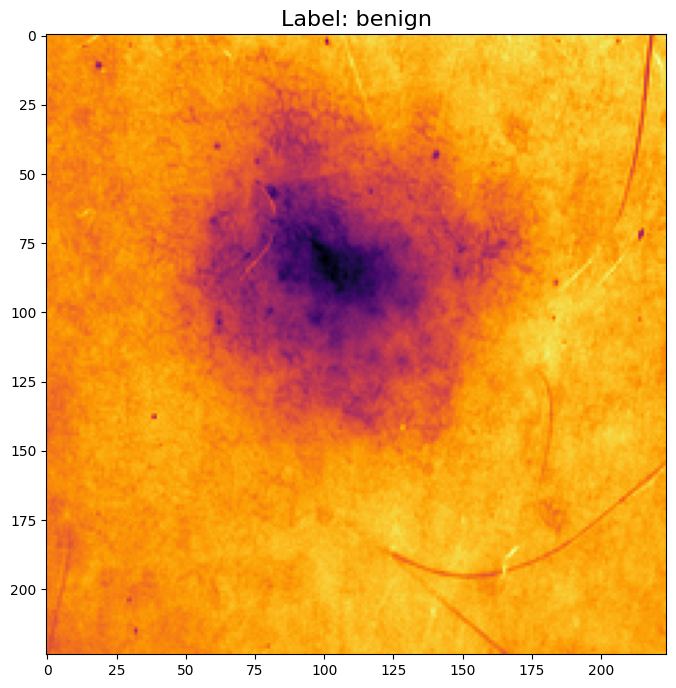

In [17]:
# Select random sample from train_df
idx = random.sample(train_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='inferno')

In [18]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1

    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')

        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]))
        else:
            plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map)

    return

view_mulitiple_samples(train_df, _load,
                       count=25, color_map='inferno',
                       fig_size=(20, 24))


Output hidden; open in https://colab.research.google.com to view.

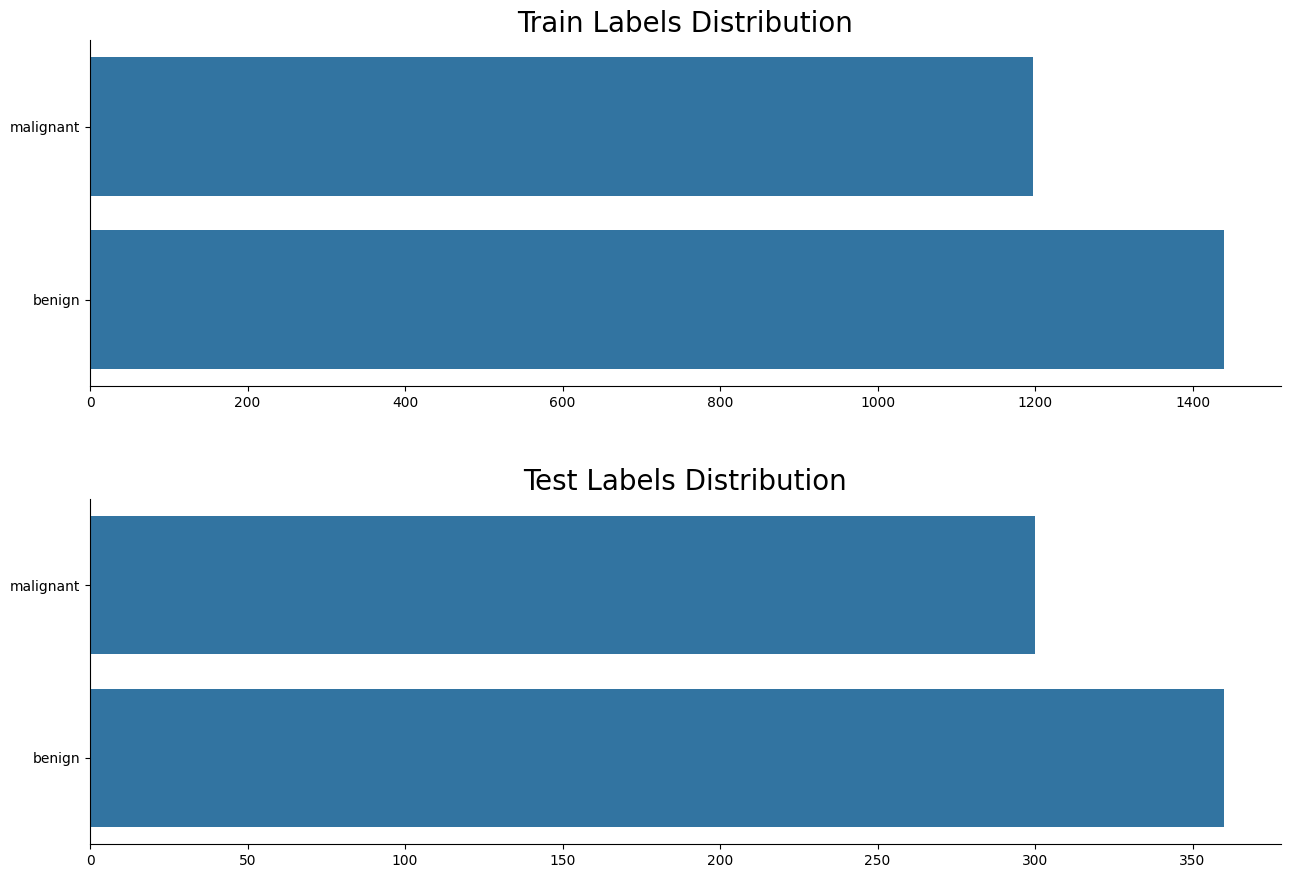

In [19]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax2);

sns.despine();

In [20]:
# Create Train/Val split with Training Set
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index,
                                                        train_df.label_encoded,
                                                        test_size=0.15,
                                                        stratify=train_df.label_encoded,
                                                        random_state=CFG.SEED)

In [21]:
# Get new training and validation data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((2241, 3), (396, 3))

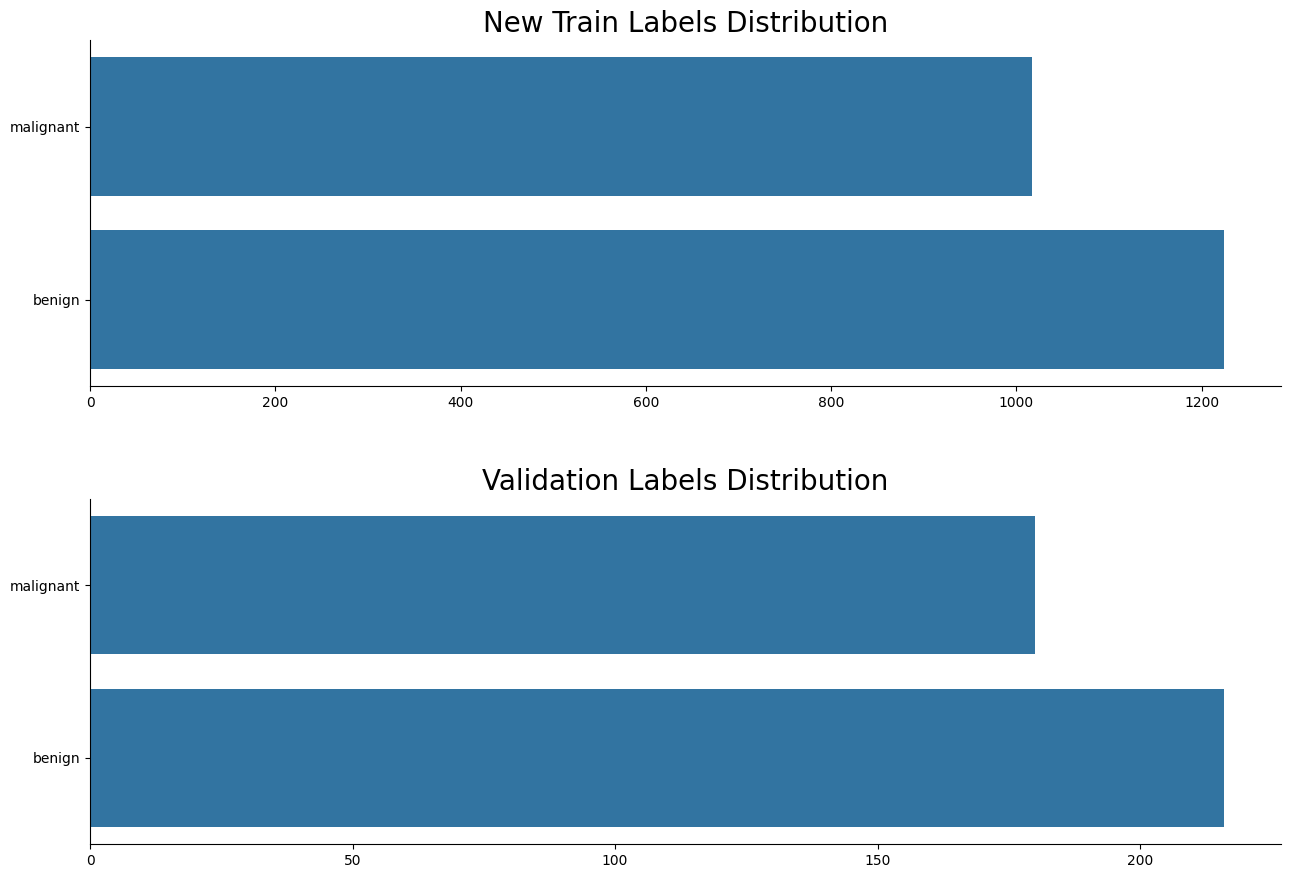

In [22]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot New Train Labels Distribution
ax1.set_title('New Train Labels Distribution', fontsize=20)
train_new_distribution = train_new_df['label'].value_counts().sort_values()
sns.barplot(x=train_new_distribution.values,
            y=list(train_new_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['label'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

sns.despine();

In [23]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

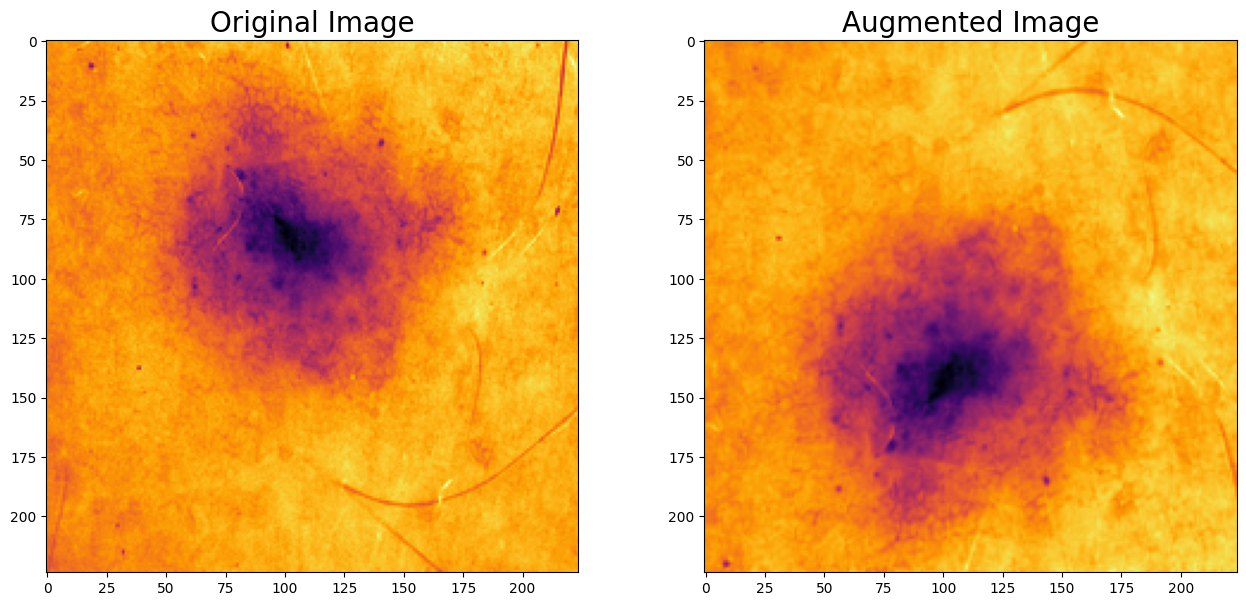

In [24]:
image = tf.image.rgb_to_grayscale(sample_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(image, cmap='inferno');

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(augmentation_layer(image), cmap='inferno');

In [26]:
def encode_labels(labels, encode_depth=2):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.

    @params
        - df: (pd.DataFrame) -> DataFrame containing paths and labels
        - load_function: (function) -> function used to load images given their paths
        - augment: (bool) -> condition for applying augmentation
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)

    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [27]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_new_df, _load, augment=True,
                           batch_size=CFG.BATCH_SIZE,
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(val_df, _load,
                         batch_size=CFG.BATCH_SIZE,
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_df, _load,
                          batch_size=CFG.BATCH_SIZE,
                          shuffle=False, prefetch=False)

In [28]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [29]:
def cnn_model():

    initializer = tf.keras.initializers.GlorotNormal()

    cnn_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),

        layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2, padding='valid'),

        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),

        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, activation='sigmoid', kernel_initializer=initializer)
    ], name='cnn_sequential_model')

    return cnn_sequential

In [30]:
# Generate Model
model_cnn = cnn_model()

# Generate Summary of the Model
model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 8)       1160      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 8)         0         
 g2D)                                         

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


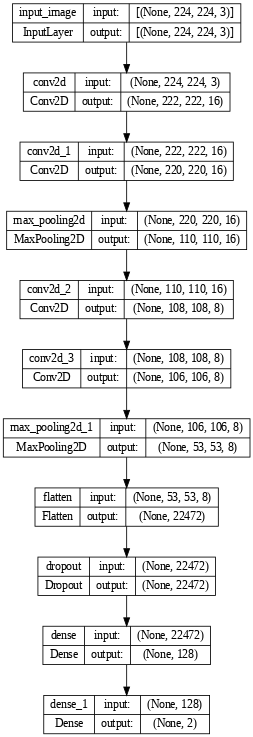

In [31]:
# Explore model visually
plot_model(
    model_cnn, dpi=60,
    show_shapes=True
)

In [32]:
def train_model(model, num_epochs, callbacks_list, tf_train_data,
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data.

        @params
        - model: (tf.keras.model) -> model to be trained
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)

        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''

    model_history = {}

    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)

    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [33]:
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

# Define Reduce Learning Rate Callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

# Define Callbacks and Metrics lists
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [34]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_cnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model
print(f'Training {model_cnn.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

cnn_history = train_model(
    model_cnn, CFG.EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training cnn_sequential_model.
Train on 2241 samples, validate on 396 samples.
----------------------------------
Epoch 1/10
71/71 [==============================] - 10s 49ms/step - loss: 0.6578 - accuracy: 0.5761 - val_loss: 0.5316 - val_accuracy: 0.7702 - lr: 0.0010
Epoch 2/10
71/71 [==============================] - 3s 40ms/step - loss: 0.5081 - accuracy: 0.7470 - val_loss: 0.5957 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 3/10
71/71 [==============================] - 3s 40ms/step - loss: 0.4945 - accuracy: 0.7510 - val_loss: 0.5265 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 4/10
71/71 [==============================] - 3s 42ms/step - loss: 0.4438 - accuracy: 0.7787 - val_loss: 0.3916 - val_accuracy: 0.8258 - lr: 0.0010
Epoch 5/10
71/71 [==============================] - 3s 40ms/step - loss: 0.4986 - accuracy: 0.7497 - val_loss: 0.4510 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 6/10
70/71 [============================>.] - ETA: 0s - loss: 0.4496 - accuracy: 0.7835
Epoch 6: ReduceLROnPl

In [35]:
# Evaluate the model
cnn_evaluation = model_cnn.evaluate(test_ds)

21/21 [==============================] - 1s 30ms/step - loss: 0.3964 - accuracy: 0.7970


In [36]:
# Generate model probabilities and associated predictions
cnn_test_probabilities = model_cnn.predict(test_ds, verbose=1)
cnn_test_predictions = tf.argmax(cnn_test_probabilities, axis=1)

21/21 [==============================] - 1s 15ms/step


In [37]:
# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [38]:
# Get EfficientNet V2 B0 here
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2'
model_name = 'efficientnet_v2_b0'

# Set trainable to False for inference-only
set_trainable=False

efficientnet_v2_b0 = get_tfhub_model(efficientnet_v2_url,
                                     model_name,
                                     model_trainable=set_trainable)

In [39]:
def efficientnet_v2_model():

    initializer = tf.keras.initializers.GlorotNormal()

    efficientnet_v2_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        efficientnet_v2_b0,
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, dtype=tf.float32, activation='sigmoid', kernel_initializer=initializer)
    ], name='efficientnet_v2_sequential_model')

    return efficientnet_v2_sequential

In [40]:
# Generate Model
model_efficientnet_v2 = efficientnet_v2_model()

# Generate Summary of the Model
model_efficientnet_v2.summary()

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2_b0 (KerasL  (None, 1280)              5919312   
 ayer)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 6083538 (23.21 MB)
Trainable params: 164226 (641.51 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


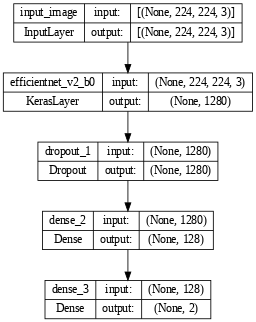

In [41]:
# Explore model visually
plot_model(
    model_efficientnet_v2, dpi=60,
    show_shapes=True
)

In [42]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_efficientnet_v2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model
print(f'Training {model_efficientnet_v2.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

efficientnet_v2_history = train_model(
    model_efficientnet_v2, CFG.EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training efficientnet_v2_sequential_model.
Train on 2241 samples, validate on 396 samples.
----------------------------------
Epoch 1/10
71/71 [==============================] - 12s 64ms/step - loss: 0.4575 - accuracy: 0.8059 - val_loss: 0.3414 - val_accuracy: 0.8535 - lr: 0.0010
Epoch 2/10
71/71 [==============================] - 3s 42ms/step - loss: 0.3234 - accuracy: 0.8568 - val_loss: 0.2964 - val_accuracy: 0.8838 - lr: 0.0010
Epoch 3/10
71/71 [==============================] - 3s 40ms/step - loss: 0.3041 - accuracy: 0.8590 - val_loss: 0.3126 - val_accuracy: 0.8687 - lr: 0.0010
Epoch 4/10
71/71 [==============================] - 3s 43ms/step - loss: 0.2836 - accuracy: 0.8639 - val_loss: 0.2743 - val_accuracy: 0.8990 - lr: 0.0010
Epoch 5/10
71/71 [==============================] - 3s 46ms/step - loss: 0.2669 - accuracy: 0.8782 - val_loss: 0.2626 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 6/10
71/71 [==============================] - 3s 40ms/step - loss: 0.2608 - accuracy: 0.8773 - va

In [43]:
# Evaluate the model
efficientnet_v2_evaluation = model_efficientnet_v2.evaluate(test_ds)

21/21 [==============================] - 1s 45ms/step - loss: 0.2760 - accuracy: 0.8727


In [44]:
# Generate model probabilities and associated predictions
efficientnet_v2_test_probabilities = model_efficientnet_v2.predict(test_ds, verbose=1)
efficientnet_v2_test_predictions = tf.argmax(efficientnet_v2_test_probabilities, axis=1)

21/21 [==============================] - 1s 19ms/step


In [45]:
!pip install -q vit-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.5 MB/s eta 0:00:00


In [47]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.0 MB/s eta 0:00:00


In [48]:
from vit_keras import vit

# Download the model
vit_model = vit.vit_b16(
    image_size=224,
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=2
)

# Freeze model layers for inference-mode only
for layer in vit_model.layers:
    layer.trainable = False

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [49]:
def vit_b16_model():

    initializer = tf.keras.initializers.GlorotNormal()

    vit_b16_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        vit_model,
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, dtype=tf.float32, activation='sigmoid', kernel_initializer=initializer)
    ], name='vit_b16_sequential_model')

    return vit_b16_sequential

In [50]:
# Generate Model
model_vit_b16 = vit_b16_model()

# Generate Summary of the Model
model_vit_b16.summary()

Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_2 (Dropout)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 85897346 (327.67 MB)
Trainable params: 98690 (385.51 KB)
Non-trainable params: 85798656 (327.30 MB)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


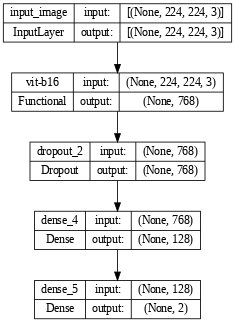

In [51]:
# Explore model visually
plot_model(
    model_vit_b16, dpi=60,
    show_shapes=True
)

In [52]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_vit_b16.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model
print(f'Training {model_vit_b16.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

vit_b16_history = train_model(
    model_vit_b16, CFG.EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training vit_b16_sequential_model.
Train on 2241 samples, validate on 396 samples.
----------------------------------
Epoch 1/10
71/71 [==============================] - 37s 347ms/step - loss: 0.4320 - accuracy: 0.8014 - val_loss: 0.3016 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 2/10
71/71 [==============================] - 21s 298ms/step - loss: 0.3581 - accuracy: 0.8434 - val_loss: 0.3156 - val_accuracy: 0.8561 - lr: 0.0010
Epoch 3/10
71/71 [==============================] - 22s 306ms/step - loss: 0.3246 - accuracy: 0.8572 - val_loss: 0.2624 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 4/10
71/71 [==============================] - 21s 301ms/step - loss: 0.3060 - accuracy: 0.8599 - val_loss: 0.2647 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 5/10
70/71 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8629
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
71/71 [==============================] - 22s 303ms/step - loss: 0.2936 - accuracy: 0.86

In [53]:
# Evaluate the model
vit_b16_evaluation = model_vit_b16.evaluate(test_ds)

21/21 [==============================] - 5s 234ms/step - loss: 0.2862 - accuracy: 0.8667


In [54]:
# Generate model probabilities and associated predictions
vit_b16_test_probabilities = model_vit_b16.predict(test_ds, verbose=1)
vit_b16_test_predictions = tf.argmax(vit_b16_test_probabilities, axis=1)

21/21 [==============================] - 8s 228ms/step


In [55]:
def plot_training_curves(history):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

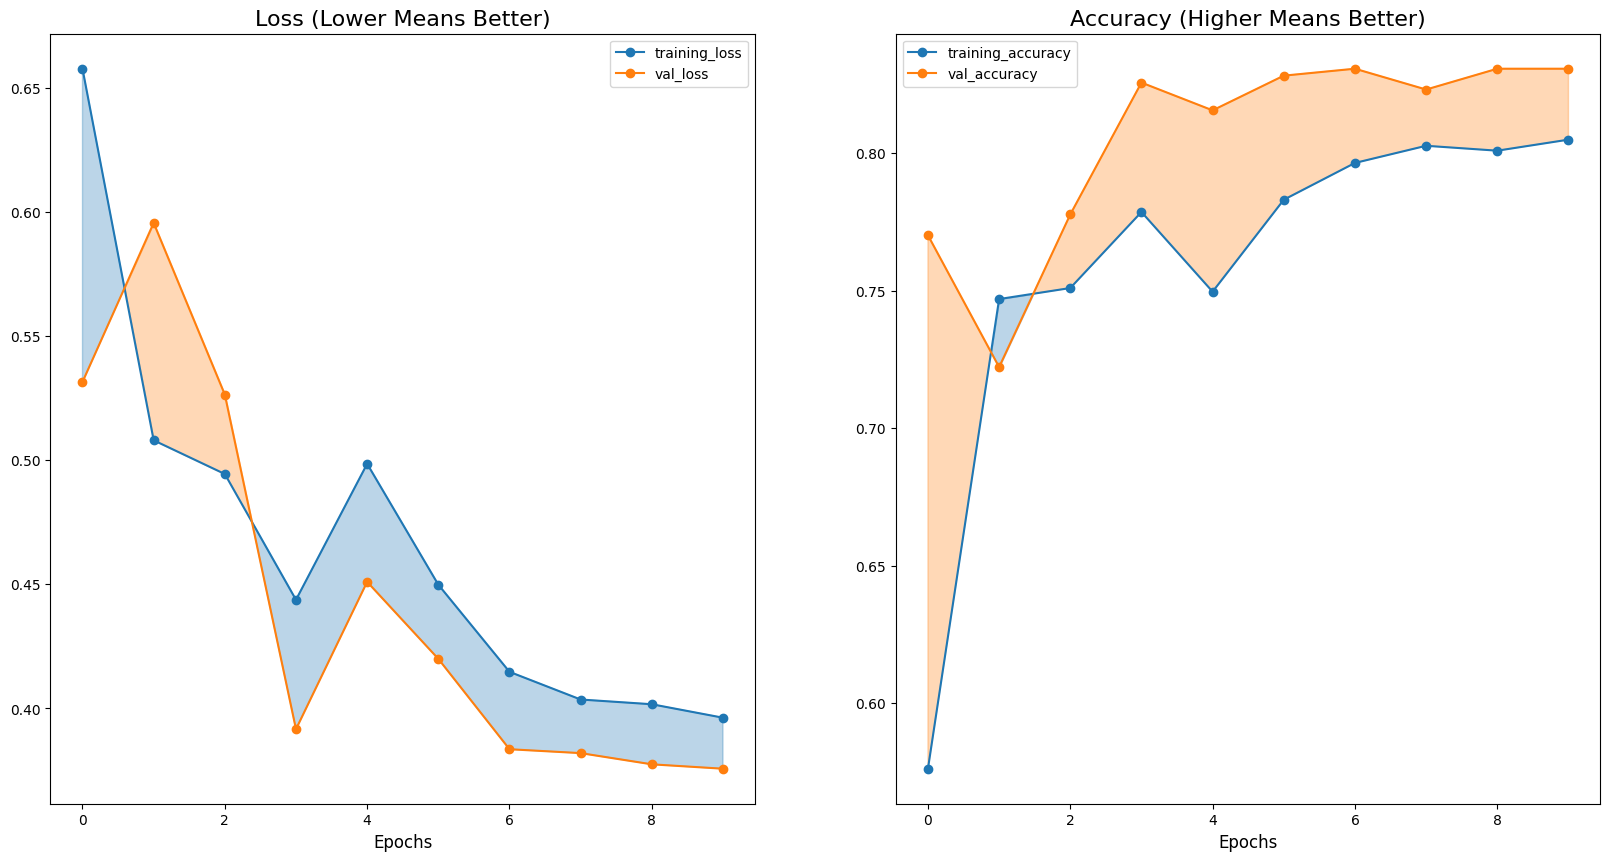

In [56]:
# plot cnn model training history
plot_training_curves(cnn_history)

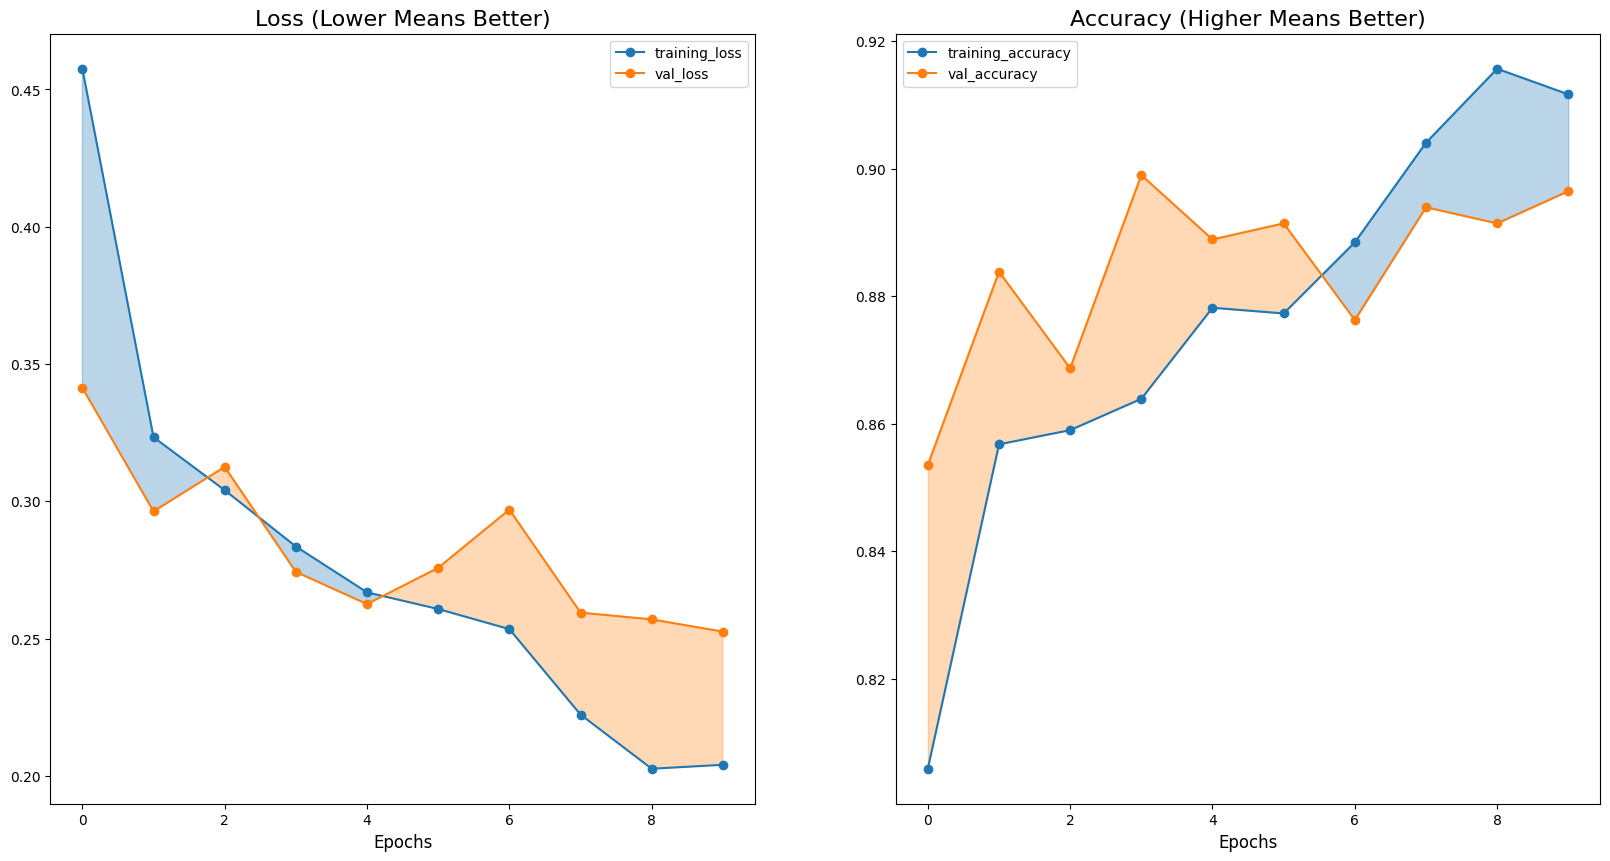

In [57]:
# Plot EfficientNet V2 B0 model training history
plot_training_curves(efficientnet_v2_history)

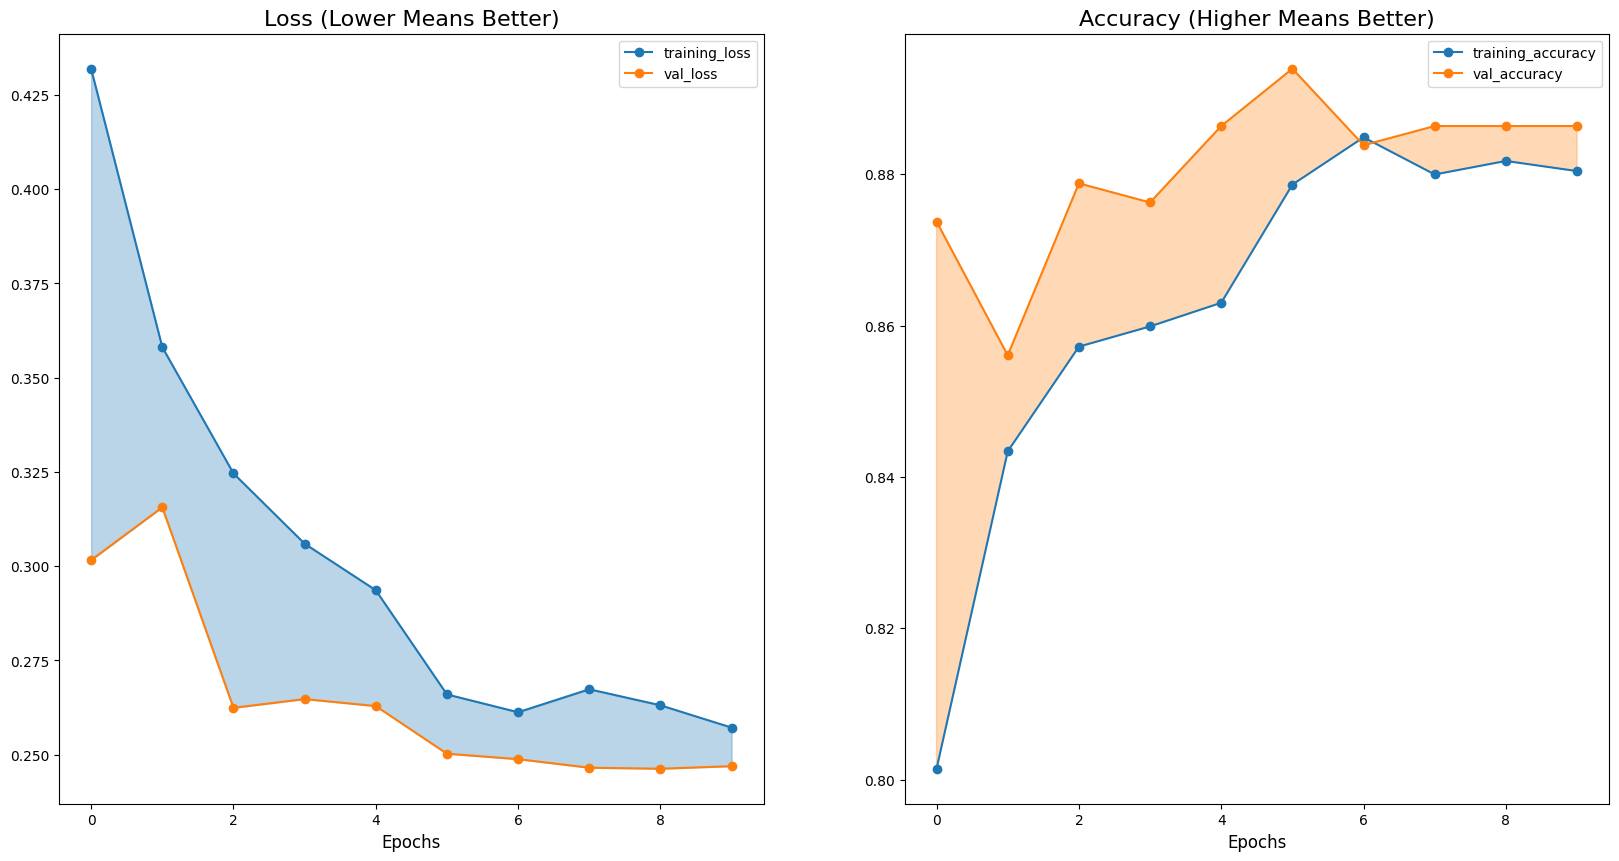

In [58]:
# Plot VIT B16 model training history
plot_training_curves(vit_b16_history)

In [59]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

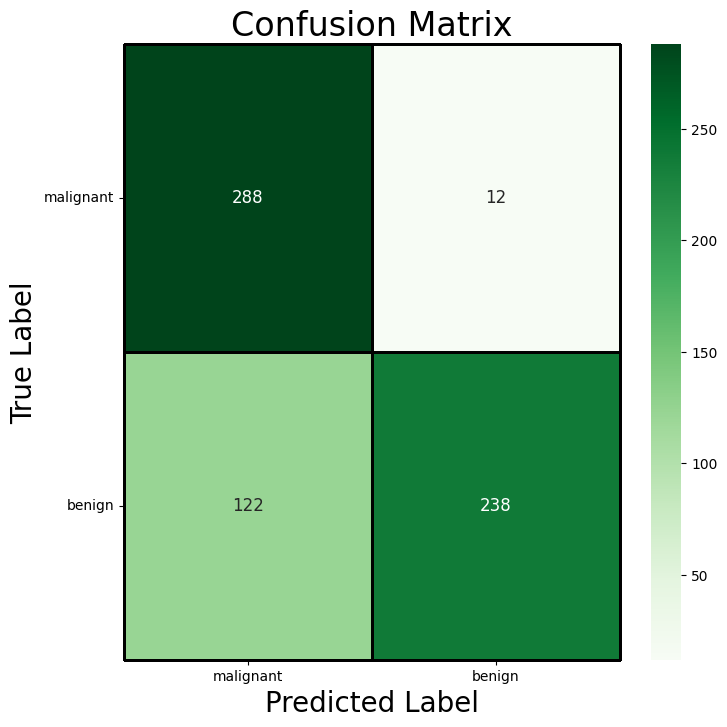

In [60]:
class_names = ['malignant', 'benign']

plot_confusion_matrix(
    test_df.label_encoded,
    cnn_test_predictions,
    figsize=(8, 8),
    classes=class_names)

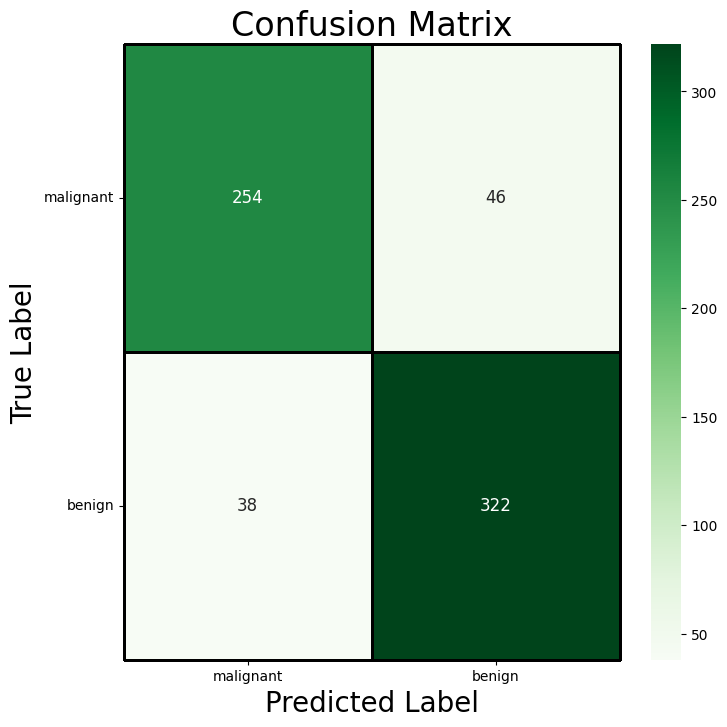

In [61]:
plot_confusion_matrix(
    test_df.label_encoded,
    efficientnet_v2_test_predictions,
    figsize=(8, 8),
    classes=class_names)

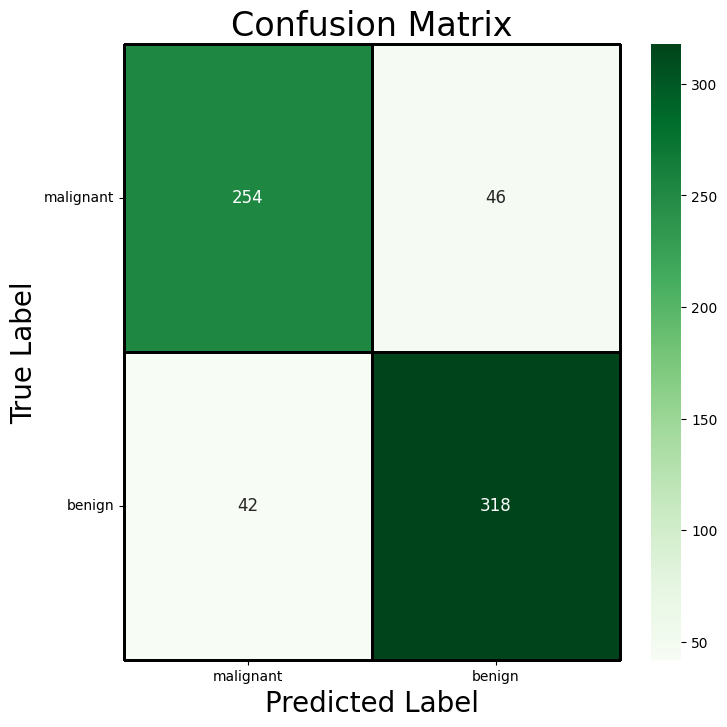

In [62]:
plot_confusion_matrix(
    test_df.label_encoded,
    vit_b16_test_predictions,
    figsize=(8, 8),
    classes=class_names)

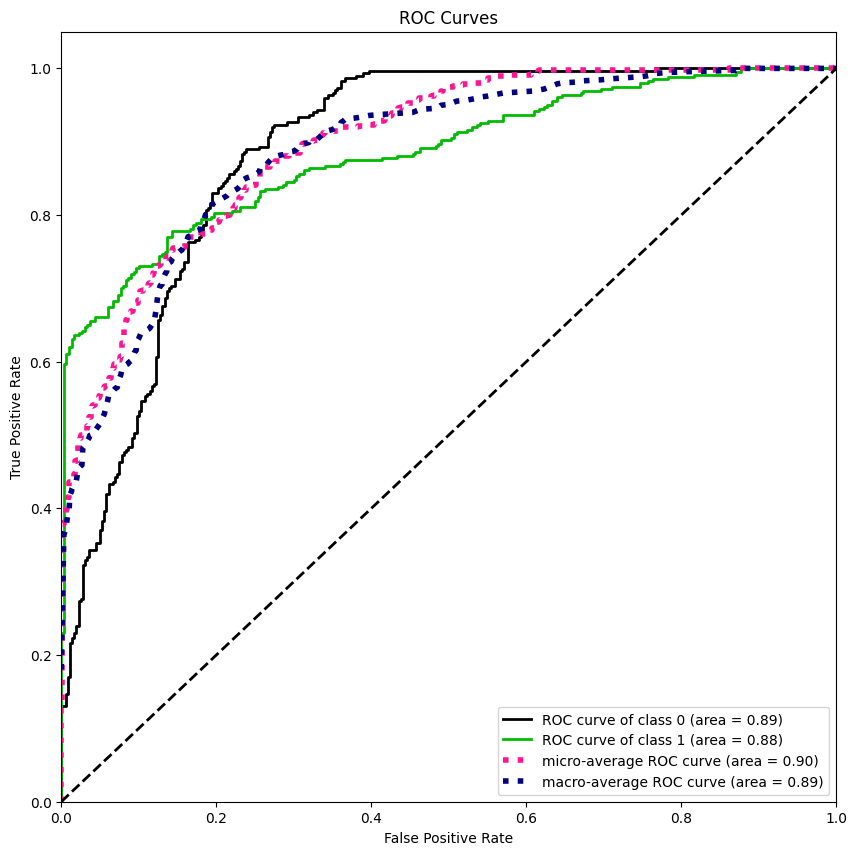

In [63]:
plot_roc(test_df.label_encoded,
         cnn_test_probabilities,
         figsize=(10, 10), title_fontsize='large');

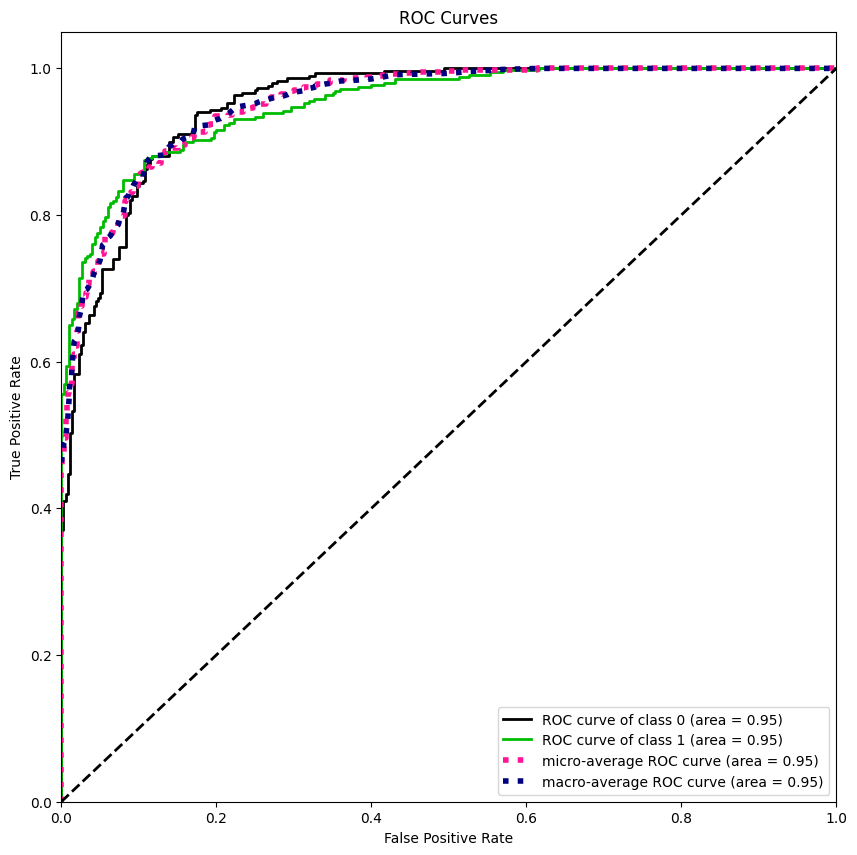

In [64]:
plot_roc(test_df.label_encoded,
         efficientnet_v2_test_probabilities,
         figsize=(10, 10), title_fontsize='large');

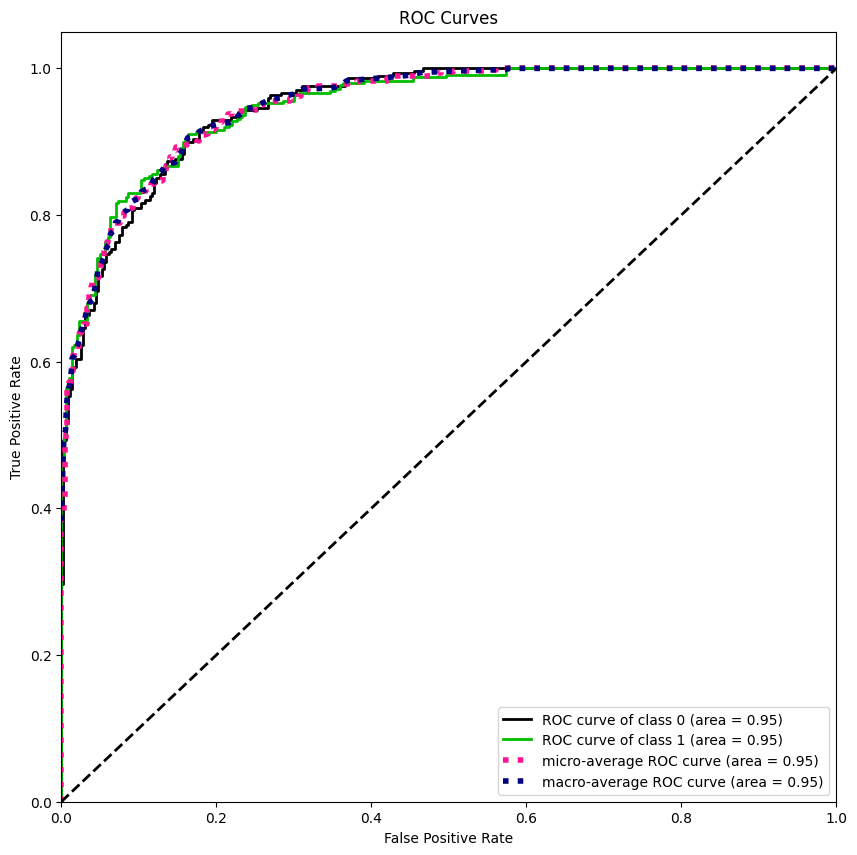

In [65]:
plot_roc(test_df.label_encoded,
         vit_b16_test_probabilities,
         figsize=(10, 10), title_fontsize='large');

In [66]:
# CNN ROC Curves
print(classification_report(test_df.label_encoded,
                            cnn_test_predictions,
                            target_names=class_names))

              precision    recall  f1-score   support

   malignant       0.70      0.96      0.81       300
      benign       0.95      0.66      0.78       360

    accuracy                           0.80       660
   macro avg       0.83      0.81      0.80       660
weighted avg       0.84      0.80      0.79       660



In [67]:
# EfficientNet V2 ROC Curves
print(classification_report(test_df.label_encoded,
                            efficientnet_v2_test_predictions,
                            target_names=class_names))

              precision    recall  f1-score   support

   malignant       0.87      0.85      0.86       300
      benign       0.88      0.89      0.88       360

    accuracy                           0.87       660
   macro avg       0.87      0.87      0.87       660
weighted avg       0.87      0.87      0.87       660



In [68]:
# ViT-b16 ROC Curves
print(classification_report(test_df.label_encoded,
                            vit_b16_test_predictions,
                            target_names=class_names))

              precision    recall  f1-score   support

   malignant       0.86      0.85      0.85       300
      benign       0.87      0.88      0.88       360

    accuracy                           0.87       660
   macro avg       0.87      0.86      0.87       660
weighted avg       0.87      0.87      0.87       660



In [69]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):

    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true,
            y_pred,
            average="weighted"
        )
    )
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')

    preformance_scores = {
        'accuracy_score': model_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores

In [70]:
# Generate CNN model performance scores
cnn_performance = generate_preformance_scores(test_df.label_encoded,
                                              cnn_test_predictions,
                                              cnn_test_probabilities)


Performance Metrics:

accuracy_score:		0.7970

_____________________________________________
precision_score:	0.8386

_____________________________________________
recall_score:		0.7970

_____________________________________________
f1_score:		0.7944

_____________________________________________
matthews_corrcoef:	0.6376



In [71]:
# Generate EfficieNet model performance scores
efficientnet_v2_performance = generate_preformance_scores(test_df.label_encoded,
                                                          efficientnet_v2_test_predictions,
                                                          efficientnet_v2_test_probabilities)


Performance Metrics:

accuracy_score:		0.8727

_____________________________________________
precision_score:	0.8727

_____________________________________________
recall_score:		0.8727

_____________________________________________
f1_score:		0.8726

_____________________________________________
matthews_corrcoef:	0.7430



In [72]:
# Generate ViT model performance scores
vit_b16_performance = generate_preformance_scores(test_df.label_encoded,
                                                  vit_b16_test_predictions,
                                                  vit_b16_test_probabilities)


Performance Metrics:

accuracy_score:		0.8667

_____________________________________________
precision_score:	0.8666

_____________________________________________
recall_score:		0.8667

_____________________________________________
f1_score:		0.8666

_____________________________________________
matthews_corrcoef:	0.7309



In [73]:
# Record metrics with DataFrame
performance_df = pd.DataFrame({
    'model_cnn': cnn_performance,
    'model_efficientnet_v2': efficientnet_v2_performance,
    'model_vit_b16': vit_b16_performance
}).T

# View Performance DataFrame
performance_df

,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
model_cnn,0.796970,0.838563,0.796970,0.794391,0.637557
model_efficientnet_v2,0.872727,0.872665,0.872727,0.872567,0.742985
model_vit_b16,0.866667,0.866573,0.866667,0.866588,0.730867


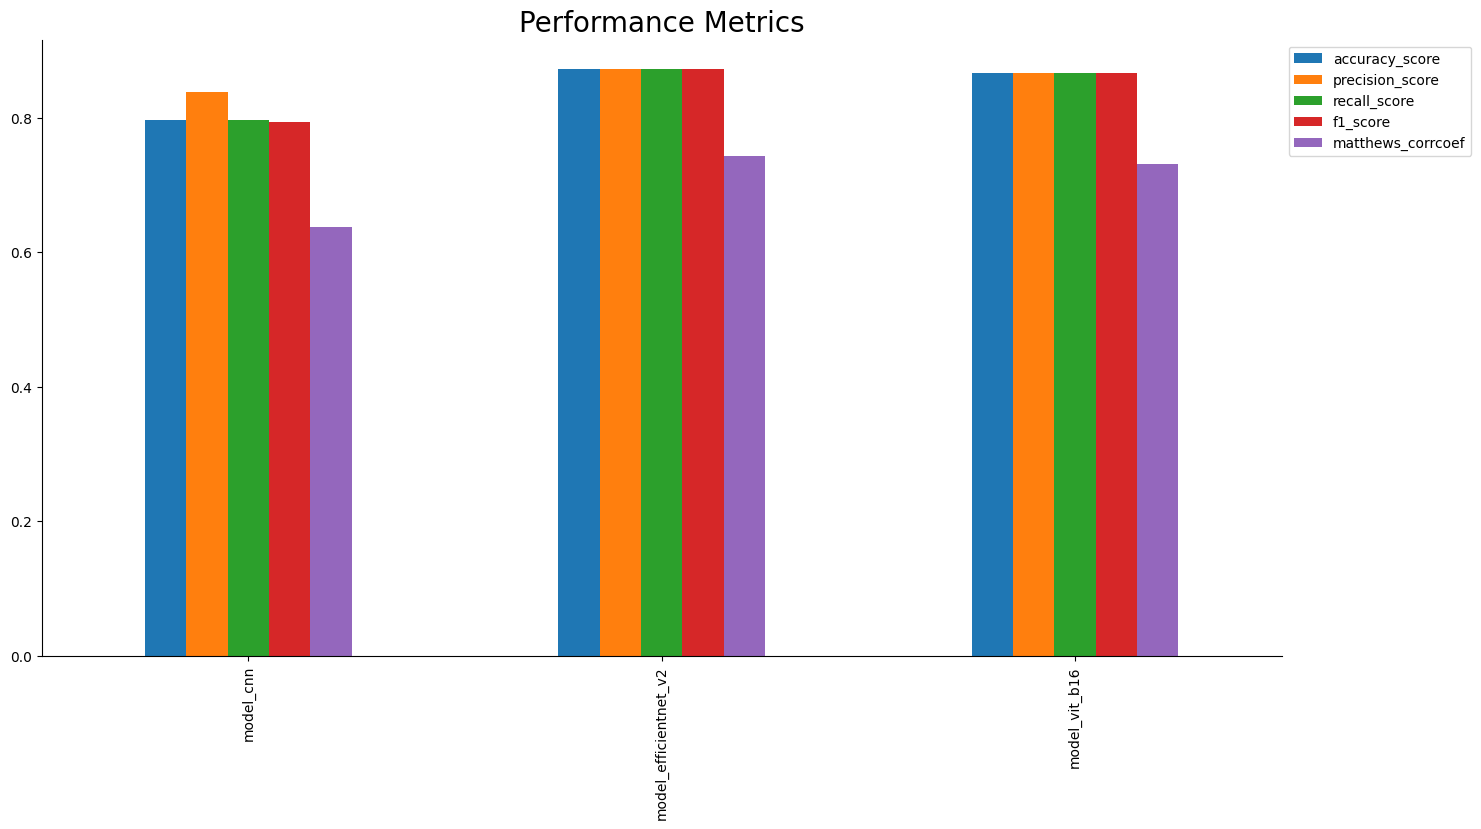

In [74]:
performance_df.plot(
    kind="bar",
    figsize=(16, 8)
).legend(bbox_to_anchor=(1.0, 1.0))

plt.title('Performance Metrics', fontsize=20);
sns.despine();

In [75]:
def compute_inference_time(model, ds, sample_count, inference_runs=5):
    total_inference_times = []
    inference_rates = []

    for _ in range(inference_runs):
        start = time.perf_counter()
        model.predict(ds)
        end = time.perf_counter()

        # Compute total inference time
        total_inference_time = end - start

        # Compute inference rate
        inference_rate = total_inference_time / sample_count

        total_inference_times.append(total_inference_time)
        inference_rates.append(inference_rate)

    # Calculate average total inference time with uncertainty
    avg_inference_time = sum(total_inference_times) / len(total_inference_times)
    avg_inference_time_uncertainty = (max(total_inference_times) - min(total_inference_times)) / 2


    # Calculate average inference rate with uncertainty
    avg_inference_rate = sum(inference_rates) / len(inference_rates)
    avg_inference_rate_uncertainty = (max(inference_rates) - min(inference_rates)) / 2

    print('====================================================')
    print(f'Model:\t\t{model.name}\n')
    print(f'Inference Time:\t{round(avg_inference_time, 6)}s \xB1 {round(avg_inference_time_uncertainty, 6)}s')
    print(f'Inference Rate:\t{round(avg_inference_rate, 6)}s/sample \xB1 {round(avg_inference_rate_uncertainty, 6)}s/sample')
    print('====================================================')

    return avg_inference_time, avg_inference_rate

In [76]:
cnn_inference = compute_inference_time(model_cnn, test_ds, len(test_df))

21/21 [==============================] - 0s 18ms/step
Model:		cnn_sequential_model

Inference Time:	0.436025s ± 0.015122s
Inference Rate:	0.000661s/sample ± 2.3e-05s/sample


In [77]:
efficientnet_v2_inference = compute_inference_time(model_efficientnet_v2, test_ds, len(test_df))

21/21 [==============================] - 0s 20ms/step
Model:		efficientnet_v2_sequential_model

Inference Time:	0.624129s ± 0.291111s
Inference Rate:	0.000946s/sample ± 0.000441s/sample


In [78]:
vit_b16_inference = compute_inference_time(model_vit_b16, test_ds, len(test_df))

21/21 [==============================] - 5s 221ms/step
Model:		vit_b16_sequential_model

Inference Time:	4.685809s ± 0.019573s
Inference Rate:	0.0071s/sample ± 3e-05s/sample


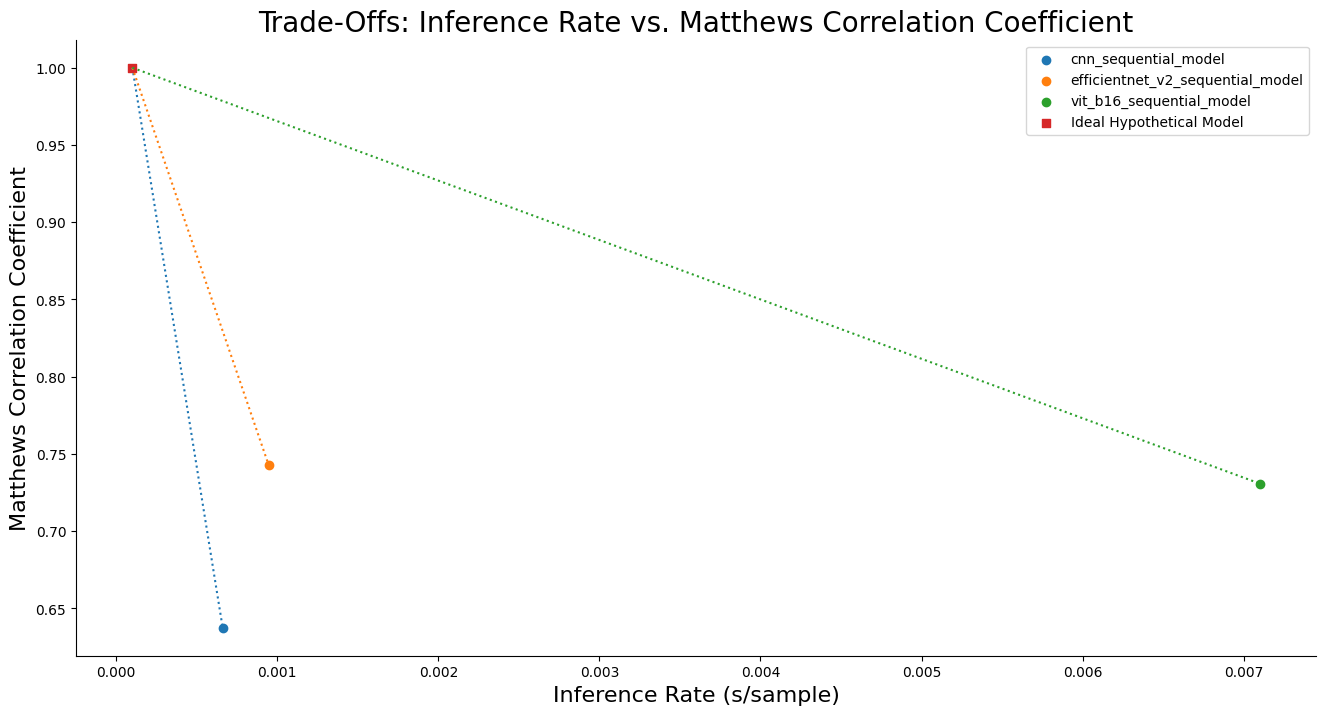

In [79]:
# Get MCC for each model
cnn_mcc = cnn_performance["matthews_corrcoef"]
efficientnet_mcc = efficientnet_v2_performance["matthews_corrcoef"]
vit_mcc = vit_b16_performance["matthews_corrcoef"]

# Scatter plot inference rate against MCC
plt.figure(figsize=(16, 8))

plt.scatter(cnn_inference[1], cnn_mcc, label=model_cnn.name)
plt.scatter(efficientnet_v2_inference[1], efficientnet_mcc, label=model_efficientnet_v2.name)
plt.scatter(vit_b16_inference[1], vit_mcc, label=model_vit_b16.name)

ideal_inference_rate = 0.0001 # Desired inference time (Exaggerated)
ideal_mcc = 1 # Max MCC

# Plot lines connecting each model coords. to the ideal model coords.
plt.scatter(ideal_inference_rate, ideal_mcc, label="Ideal Hypothetical Model", marker='s')
plt.plot([ideal_inference_rate, cnn_inference[1]], [ideal_mcc, cnn_mcc], ':')
plt.plot([ideal_inference_rate, efficientnet_v2_inference[1]], [ideal_mcc, efficientnet_mcc], ':')
plt.plot([ideal_inference_rate, vit_b16_inference[1]], [ideal_mcc, vit_mcc], ':')

plt.legend()
plt.title("Trade-Offs: Inference Rate vs. Matthews Correlation Coefficient", fontsize=20)
plt.xlabel("Inference Rate (s/sample)", fontsize=16)
plt.ylabel("Matthews Correlation Coefficient", fontsize=16);

sns.despine();

In [80]:
def dist(x1, x2, y1, y2):
    return np.sqrt(np.square(x2 - x1) + np.square(y2 - y1))

model_names = [model_cnn.name, model_efficientnet_v2.name, model_vit_b16.name]
model_scores = [cnn_mcc, efficientnet_mcc, vit_mcc]
model_rates = [cnn_inference[1], efficientnet_v2_inference[1], vit_b16_inference[1]]
trade_offs = [dist(ideal_inference_rate, inference_rate, ideal_mcc, score)
              for inference_rate, score in zip(model_rates, model_scores)]

print('Trade-Off Score: Inference Rate vs. MCC')
for name, inference_rate, score, trade in zip(model_names, model_rates, model_scores, trade_offs):
    print('---------------------------------------------------------')
    print(f'Model: {name}\n\nInference Rate: {inference_rate:.5f} | MCC: {score:.4f} | Trade-Off: {trade:.4f}')

# View model with best trade-off score
print('=========================================================')
best_model_trade = min(trade_offs)
best_model_name = model_names[np.argmin(trade_offs)]
print(f'\nBest Optimal Model:\t{best_model_name}\nTrade-Off:\t\t{best_model_trade:.4f}\n')
print('=========================================================')

Trade-Off Score: Inference Rate vs. MCC
---------------------------------------------------------
Model: cnn_sequential_model

Inference Rate: 0.00066 | MCC: 0.6376 | Trade-Off: 0.3624
---------------------------------------------------------
Model: efficientnet_v2_sequential_model

Inference Rate: 0.00095 | MCC: 0.7430 | Trade-Off: 0.2570
---------------------------------------------------------
Model: vit_b16_sequential_model

Inference Rate: 0.00710 | MCC: 0.7309 | Trade-Off: 0.2692

Best Optimal Model:	efficientnet_v2_sequential_model
Trade-Off:		0.2570



In [81]:
test_df

,image_path,label,label_encoded
0,/content/skin-cancer-malignant-vs-benign/test/...,benign,1
1,/content/skin-cancer-malignant-vs-benign/test/...,benign,1
2,/content/skin-cancer-malignant-vs-benign/test/...,malignant,0
3,/content/skin-cancer-malignant-vs-benign/test/...,benign,1
4,/content/skin-cancer-malignant-vs-benign/test/...,malignant,0
...,...,...,...
655,/content/skin-cancer-malignant-vs-benign/test/...,malignant,0
656,/content/skin-cancer-malignant-vs-benign/test/...,malignant,0
657,/content/skin-cancer-malignant-vs-benign/test/...,malignant,0
658,/content/skin-cancer-malignant-vs-benign/test/...,benign,1


In [82]:
def view_multiple_predictions(df, model, sample_loader, count=10, color_map='rgb', title=None, fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1

    idx = random.sample(df.index.to_list(), count)

    fig = plt.figure(figsize=fig_size)
    if title != None:
        fig.suptitle(title, fontsize=30)

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Setup useful dictionaries
    label_set = {0: 'malignant', 1: 'benign'}
    color_set = {False: 'red', True: 'darkgreen'}

    for column, _ in enumerate(idx):
        # Predict label
        img = sample_loader(df.image_path[_])
        probability = np.squeeze(
            model.predict(np.array([img]), verbose=0)
        )
        prediction = np.argmax(probability)

        # Validate prediction correctness
        correct_prediction = (prediction == df.label_encoded[_])

        # Create subplot and assign title
        ax = plt.subplot(rows, 5, column+1)
        ax.set_title(
            f'Actual Label: {df.label[_]}',
            pad=20,
            fontsize=14,
            color=color_set[correct_prediction]
        )

        # Plot image
        if color_map=='rgb':
            ax.imshow(img)
        else:
            ax.imshow(tf.image.rgb_to_grayscale(img), cmap=color_map)

        # Plot prediction  & probability
        txt = f'Prediction: {label_set[prediction]}\nProbability: {(100 * probability[prediction]):.2f}%'
        plt.xlabel(txt, fontsize=14, color=color_set[correct_prediction])

    return

In [83]:
# View CNN predictions
view_multiple_predictions(
    test_df,
    model_cnn,
    _load,
    count=25,
    color_map='inferno',
    title='CNN Test Predictions',
    fig_size=(20, 28)
)

Output hidden; open in https://colab.research.google.com to view.

In [84]:
# View EfficientNet V2 predictions
view_multiple_predictions(
    test_df,
    model_efficientnet_v2,
    _load,
    count=25,
    color_map='inferno',
    title='EfficientNet V2 Test Predictions',
    fig_size=(20, 28)
)

Output hidden; open in https://colab.research.google.com to view.

In [85]:
# View Vision Transformer predictions
view_multiple_predictions(
    test_df,
    model_vit_b16,
    _load,
    count=25,
    color_map='inferno',
    title='ViT Test Predictions',
    fig_size=(20, 28)
)

Output hidden; open in https://colab.research.google.com to view.